# Importing Data 

In [ ]:
import numpy as np
import math
import os
import traceback
from scipy import signal
from scipy import optimize
import UDIP_Lib.UDIP_4_Lib_V2 as UDIP_Lib_3  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

ModuleNotFoundError: No module named 'RockSat_1_14_fitting_functions'

In [36]:
year = 2024
sourceName = 'UDIP114.dat'
#packets = import_data(f'../{year}/{year}_packet.json')
packets = import_data(f'{year}_packet_25.json')

# Get Sweep and Saving Figures

In [3]:
def get_sweep(sw, cn = 0):

  sec = np.linspace(0, 1, 5)

  start = sw['Start'] / 1000 # convert milliseconds to seconds
  stop =  sw['Stop'] / 1000

  sw['Voltage'] = np.array(sw['Voltage'])
  sw[f'Current{cn}'] = np.array(sw[f'Current{cn}'])

  V1 = sw['Voltage']     [0: int(sec[1] * len(sw['Voltage' ]))]
  I1 = sw[f'Current{cn}'][0: int(sec[1] * len(sw[f'Current1']))]

  V2 = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[2]*len(sw['Current1'])) ]
  I2 = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[2]*len(sw['Current1'])) ]

  V3 = sw['Voltage']     [int(sec[2]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  I3 = sw[f'Current{cn}'][int(sec[2]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ] 

  V4 = sw['Voltage']     [int(sec[3]*len(sw['Voltage' ]))      :int(sec[4]*len(sw['Current1'])) ]
  I4 = sw[f'Current{cn}'][int(sec[3]*len(sw[f'Current{cn}']))  :int(sec[4]*len(sw['Current1'])) ]

  Vf = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  If = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ]
  return start, stop, V1, I1, V2, I2, V3, I3, V4, I4

# Generate Sweep Images - Every 100

In [4]:
sw_range = np.arange(0,int(len(packets['packets']['Medium'])), 100) 

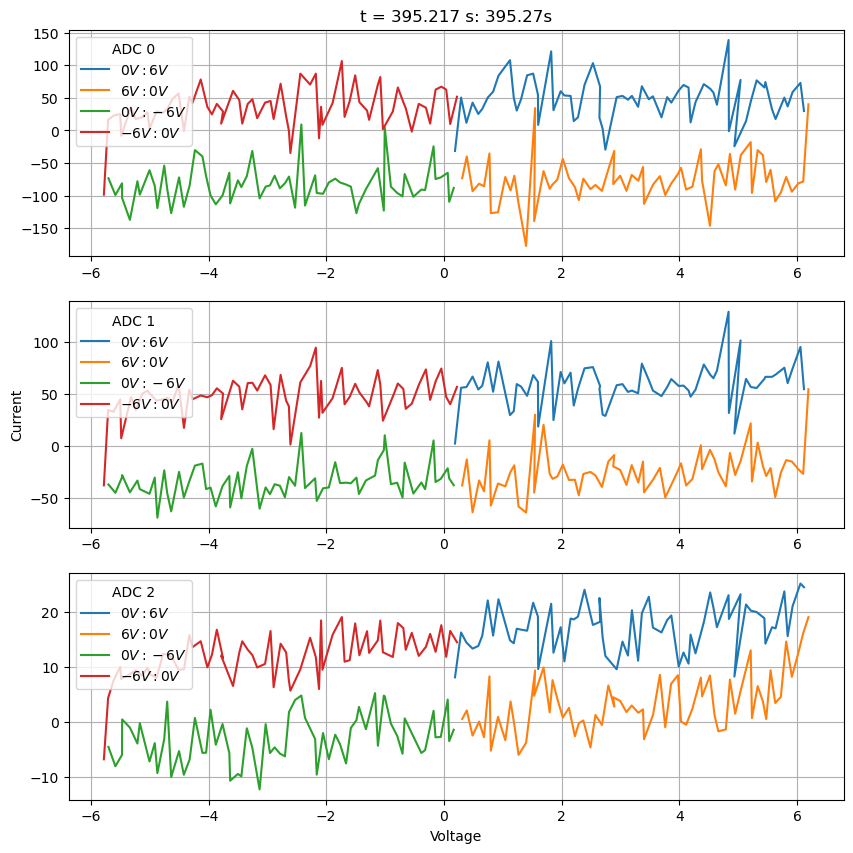

In [5]:
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in sw_range:
  for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
  axs[0].set_title(f't = {start} s: {stop}s')
  axs[2].set_xlabel('Voltage')
  axs[1].set_ylabel('Current')
  #plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

# Ground Software Testing

In [37]:
sensorNum = 10
Sensor = packets['packets']['Sensor'][f'{sensorNum}']

print(Sensor)

{'Start': 2811, 'Stop': 2818, 'Count': 10, 'Acceleration': [-0.013908, -0.002928, 0.665388, [65535]], 'Spin Rate': [0.0, 19.53, 38.150000000000006], 'Magnetic Field': [-0.76174, -0.6536599999999999, -3.4428799999999997], 'Temperature': [105.375], 'Photo Diode': [16878]}


In [38]:
print(sourceName)
print()
SensNum = len(packets['packets']['Sensor'])
print(f'There are {SensNum} Sensor packets')
print()
LinSweepNum = len(packets['packets']['Full'])
print(f'There are {LinSweepNum} Linear Sweeps')
print()
DensSweepNum = len(packets['packets']['Dense'])
print(f'There are {DensSweepNum} Dense Sweeps')

UDIP114.dat

There are 4591 Sensor packets

There are 911 Linear Sweeps

There are 102 Dense Sweeps


In [40]:
def data_processing(V, I):
    #Imax = np.argmax(I) #find index of maximum Current
    Imax = max(I)  # Find the maximum current value
    #print(f'Imax = {Imax}')
    #Imin = np.argmin(I) #find index of minimum Current
    Imin = min(I)  # Find the minimum current value
    #print(f'Imin = {Imin}')

    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        #if ((V[i] > V[Vmax_Imax]) & (V[i] < V[Vmin_Imin])):
        #if ((V[i] > -0.8) & (V[i] < 0.5)):
        if((I[i] > (Imin + 9e-10)) & (I[i] < (Imax - 9e-10))):
            V_proc.append(V[i])
            I_proc.append(I[i])
    
    return V_proc, I_proc

In [41]:
def jarrod_fit(V_arr, I_arr, adcNum):
    
    V_proc, I_proc = V_arr, I_arr
    
    if(adcNum == 0):
        guess = [-1e-7, 6.3e-7]    #intial guess (m, b)
        #b = ((-np.inf, -24937.5e-9),(np.inf, 22062.5e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 1):
        guess = [-1e-7, 6.5e-7]    #intial guess (m, b)
        #b = ((-np.inf, -1234.1e-9),(np.inf, 1050.6e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 2):
        guess = [-1e-7, 5.8e-8]    #intial guess (m, b)
        #b = ((-np.inf, -50.03e-9),(np.inf, 58.8e-9)) #bounds
        #b = ((-np.inf, -58.8e-9),(np.inf, 50.03e-9)) #bounds
        #b = ((-np.inf, -5.8e-8),(np.inf, 5.8e-8)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
        V_proc, I_proc = data_processing(V_arr, I_arr)

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov


def model(V, m1, b):
    return lin_fit(V, m1, b)


def lin_fit(x, m, y_int): # linear fit
    return m * x + y_int

adc0_min = -24937.5e-9  # Amps
adc0_max = 22062.5e-9

acd1_min = -1234.1e-9
adc1_max = 1050.6e-9

adc2_min = -58.8e-9
adc2_max = 50.03e-9


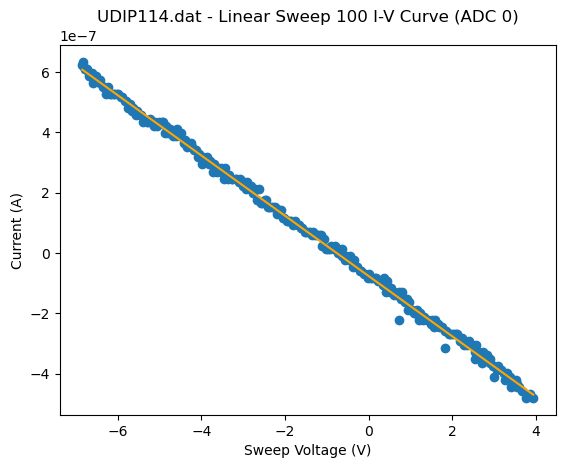

ADC_0 Slope = -1.0004e-07
ADC_0 Standard Error = 3.1230e-10


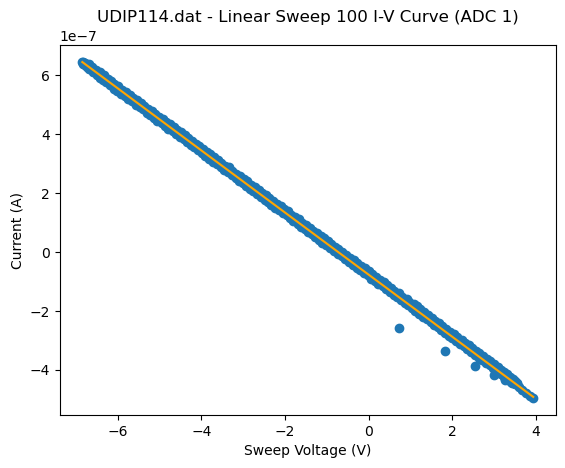

ADC_1 Slope = -1.0552e-07
ADC_1 Standard Error = 3.1484e-10


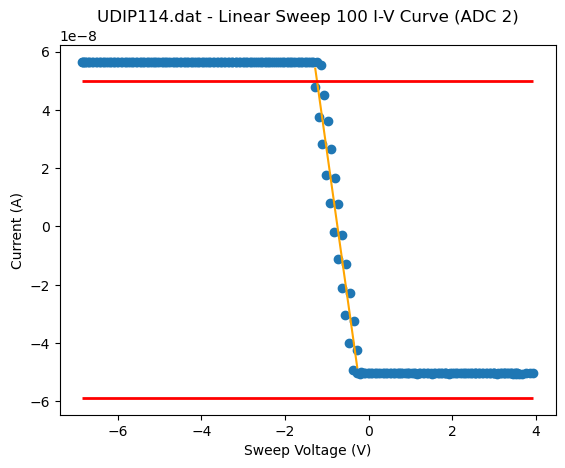

ADC_2 Slope = -1.0220e-07
ADC_2 Standard Error = 7.9438e-09


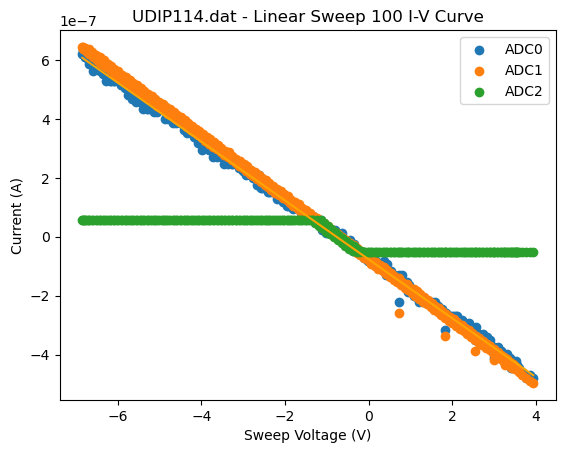

ADC_0 Slope = -1.0004e-07
ADC_1 Slope = -1.0552e-07
ADC_2 Slope = -1.0220e-07

ADC_0 Standard Error = 3.1230e-10
ADC_1 Standard Error = 3.1484e-10
ADC_2 Standard Error = 7.9438e-09


In [42]:
sweepNum = 100
V = packets['packets']['Full'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Full'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Full'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Full'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I2),len(I2))
# plt.scatter(num,I2)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - ADC 2 Values in order')
# plt.show()

# num = np.linspace(1,len(V),len(V))
# plt.scatter(num,V)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - Voltage Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = jarrod_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = jarrod_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = jarrod_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = jarrod_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')

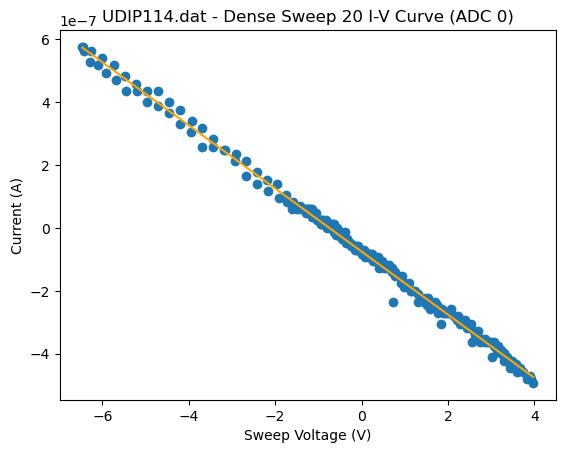

ADC_0 Slope = -1.0027e-07
ADC_0 Standard Error = 4.2422e-10


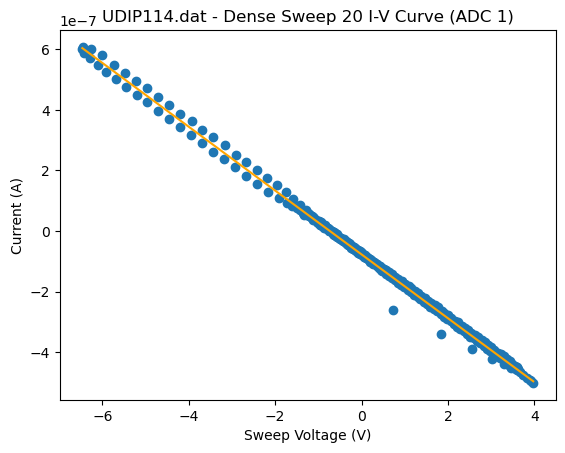

ADC_1 Slope = -1.0534e-07
ADC_1 Standard Error = 4.3817e-10


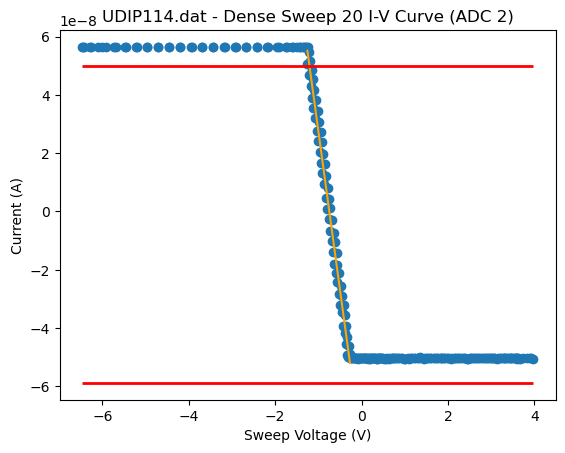

ADC_2 Slope = -1.0873e-07
ADC_2 Standard Error = 1.9358e-09


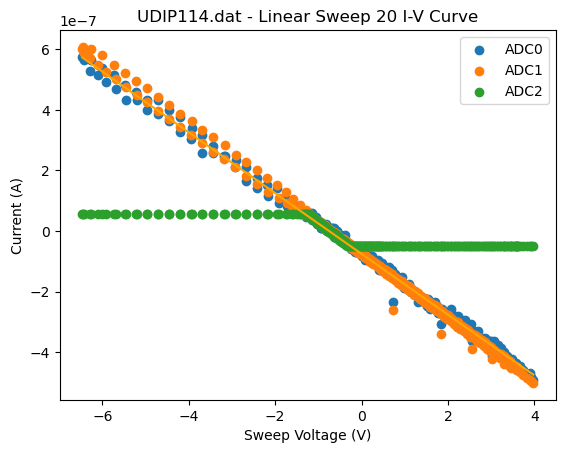

ADC_0 Slope = -1.0027e-07
ADC_1 Slope = -1.0534e-07
ADC_2 Slope = -1.0873e-07

ADC_0 Standard Error = 4.2422e-10
ADC_1 Standard Error = 4.3817e-10
ADC_2 Standard Error = 1.9358e-09


In [47]:
sweepNum = 20
V = packets['packets']['Dense'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Dense'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Dense'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Dense'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I0),len(I0))
# plt.scatter(num,I0)
# plt.title(f'{sourceName} - Dense Sweep {sweepNum} - ADC 0 Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = jarrod_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = jarrod_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = jarrod_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = jarrod_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')



The average time step in UDIP7.dat is 384.28993435448575


Text(0, 0.5, 'tFinal - tFinalPrev Difference')

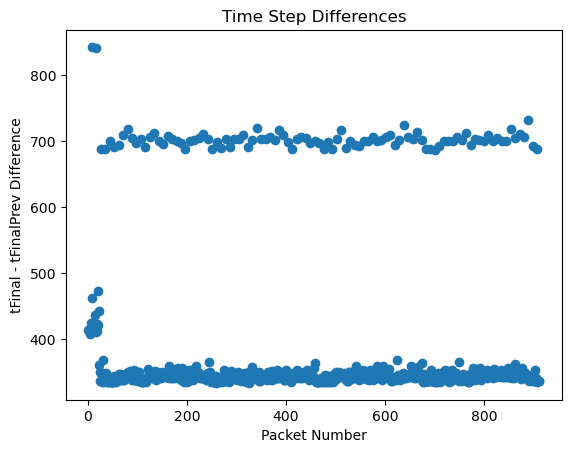

In [19]:
sweepNum = 10
tAvg = 0
packetsLen = len(packets['packets']['Full'])
#V = packets['packets']['Full'][f'{sweepNum}']['Voltage']
tDiffArr = []
for i in range(1, packetsLen):
#for i in range(1, 165):
    tInitial = packets['packets']['Full'][f'{i}']['Start']
    tFinal = packets['packets']['Full'][f'{i}']['Stop']
    #print(f'Packet {i} tInitial - {tInitial}')
    if(i > 1):
        tInitialPrev = packets['packets']['Full'][f'{i-1}']['Start']
        tFinalPrev = packets['packets']['Full'][f'{i-1}']['Stop']
        tFinalDiff = tFinal - tFinalPrev
        tInitialDiff = tInitial - tInitialPrev
        tAvg = tAvg + tInitialDiff
        tDiffArr.append(tFinalDiff)

tAvg = tAvg/packetsLen
#tAvg = tAvg/164
print()
print(f'The average time step in {sourceName} is {tAvg}')

num = np.linspace(1,len(tDiffArr),len(tDiffArr))
plt.scatter(num, tDiffArr)
plt.title('Time Step Differences')
plt.xlabel('Packet Number')
plt.ylabel('tFinal - tFinalPrev Difference')

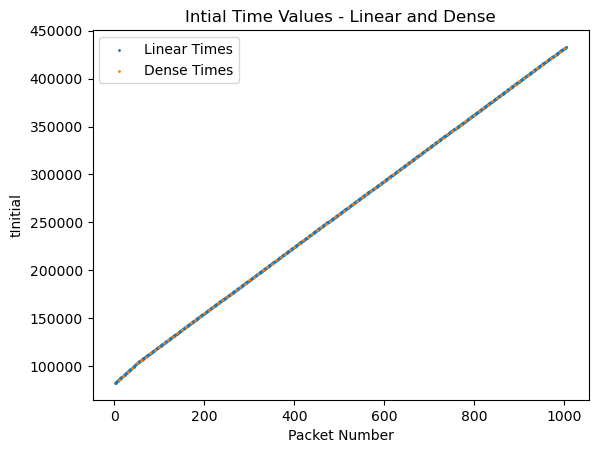

In [9]:
sweepNum = 10
packetsLen = len(packets['packets']['Full'])

tInitialArr_Lin = []
tCountArr_Lin = []

tInitialArr_Dens = []
tCountArr_Dens = []

for i in range(1, packetsLen):
    
    tInitial_Lin = packets['packets']['Full'][f'{i}']['Start']
    count_Lin = packets['packets']['Full'][f'{i}']['Count']
    
    tInitialArr_Lin.append(tInitial_Lin)
    tCountArr_Lin.append(count_Lin)
    
    if(i < len(packets['packets']['Dense'])):
        tInitial_Dens = packets['packets']['Dense'][f'{i}']['Start']
        count_Dens = packets['packets']['Dense'][f'{i}']['Count']
        
        tInitialArr_Dens.append(tInitial_Dens)
        tCountArr_Dens.append(count_Dens)

num = np.linspace(1,len(tInitialArr_Lin),len(tInitialArr_Lin))
num2 = np.linspace(1,len(tInitialArr_Dens),len(tInitialArr_Dens))

plt.scatter(tCountArr_Lin,tInitialArr_Lin, label = "Linear Times", s = 1)
plt.scatter(tCountArr_Dens,tInitialArr_Dens, label = "Dense Times", s = 1)
plt.title(f'Intial Time Values - Linear and Dense')
plt.xlabel('Packet Number')
plt.ylabel('tInitial')
plt.legend()
plt.show()

In [18]:
sensor = packets['packets']['Sensor']
print(len(sensor))
for i in range(0, len(sensor)):
    accel = sensor[f'{i}']['Acceleration']
    print(f'acceleration {i}: {accel}')

4030
acceleration 0: [0.079056, -0.00732, 0.671976, [65535]]
acceleration 1: [0.081984, -0.00732, 0.67344, [65535]]
acceleration 2: [0.083448, -0.009516, 0.672708, [65535]]
acceleration 3: [0.083448, -0.01098, 0.668316, [65535]]
acceleration 4: [0.085644, -0.01098, 0.66612, [65535]]
acceleration 5: [0.082716, -0.01098, 0.665388, [65535]]
acceleration 6: [0.07466400000000001, -0.012444, 0.668316, [65535]]
acceleration 7: [0.085644, -0.005856, 0.672708, [65535]]
acceleration 8: [0.087108, -0.01098, 0.663924, [65535]]
acceleration 9: [0.085644, -0.006588, 0.664656, [65535]]
acceleration 10: [0.085644, -0.009516, 0.666852, [65535]]
acceleration 11: [0.087108, -0.013908, 0.668316, [65535]]
acceleration 12: [0.083448, -0.006588, 0.666852, [65535]]
acceleration 13: [0.084912, -0.00732, 0.66978, [65535]]
acceleration 14: [0.08637600000000001, -0.00732, 0.667584, [65535]]
acceleration 15: [0.08418, -0.012444, 0.665388, [65535]]
acceleration 16: [0.084912, -0.005124, 0.671976, [65535]]
accelerat

# Plot a Single Sweep

In [6]:
sweepNum = 1000
fp = getFloatingPotential(sweepNum)
plsm = getPlasmaPotential(sweepNum)
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{sweepNum}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
axs[0].axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
axs[0].axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
axs[0].legend(title = f'ADC 0', loc = 'upper left')
axs[0].set_title(f'Sweep {sweepNum} (t = {start} - {stop}s)')
axs[2].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
#plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

NameError: name 'getFloatingPotential' is not defined

# Objectives

Use gen fit 
 * popt = optimize parameters
  t is x, y is model 
extract popt  it will be an array of values array of values
* (Around 30)
Plot it to check to see if you have a good fit 

**Note**: Use Sweeps 1000 - 1900 as they show the best IV curves

* x, y, popt, pcov = genfit(V, I)
    * x and y will be your fitted IV curve
    * popt is an array of m, b ,and a
* look at electron saturation region eq, inside equation is B, get Te from that since everything is a constant besdies Te
* Look at line 44 in rock sat fitting functions 

Use log linear fit for voltage instead of normal linear fit

_Q_: What are the units for the output?
* T is in Kelvin
* n is in m^3

# Fitting Functions

In [ ]:
def jarrod_fit(sweepNum):
    V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
    I = packets['packets']['Medium'][f'{sweepNum}']['Current0']
    x_raw, y_raw = np.array(V), np.array(I)
    x,y = data_processing(x_raw,y_raw)
    # x,y = R_fitting.data_processing(x_raw,y_raw)
    # g = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    #change 10000 to something lower for temperature bounds
    b = ((-3, -3, -np.inf, -np.inf, 0, 0, -3, -3), (3, 3, np.inf, np.inf, np.inf, 10000, 3, 3))  # bounds
    popt, pcov = optimize.curve_fit(model, x, y, p0=[0.6,0.8,-14,80, 5*(10**10),1000,-0.5,-0.5], bounds=b)
    
    t = np.linspace(min(x), max(x), num=264)
    return t, model(t,*popt),popt,pcov #popt[0:fp,1:plsm,2:offset,3:ionSlope,4:n,5:temp,6:V0,7:Vp]

def printIVAnalysis(sweepNum):
    x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I
    fp, plsm, offset, ionSlope, n, temp, V0, Vp = popt
    print(f'popt = {popt}')
    print('')
    print(f'The floating potential is {round(fp, 3)} V.')
    print(f'The plasma potential is {round(plsm, 3)} V.')
    print(f'The current offset is {round(offset, 3)} nA.')
    print(f'The ion saturation slope is {round(ionSlope, 3)}.')
    print(f'The electron density is {round(n, 3)} cm^(-3).')
    print(f'The electron temperature is {round(temp, 3)} K.')
    print(f'The voltage offset is {round(V0, 3)} V.')
    print('')

In [ ]:
def model(x, xf, xp, b, m1, n, t, V0, Vp):
    # changed to be hopefully more efficient
    ret = np.zeros(len(x))
    for i in range(0, len(x)):
        if(x[i] <= xf):
            ret[i] = seg1(x[i], m1) - seg1(xf, m1) + b
        # Something wrong with this part, messes up the fit ##################################################
        elif(xf < x[i] <= xp):
            ret[i] = seg2(x[i], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
        ######################################################################################################
        elif(x[i] > xp):
            ret[i] = seg3(x[i], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
        
    # ret[x <= xf] = seg1(x[x <= xf], m1) - seg1(xf, m1) + b
    # ret[x > xp] = seg3(x[x > xp], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
    # ret[xf < x <= xp] = seg2(x[xf < x <= xp], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
    return ret

In [ ]:
def seg1(x, m):  # linear--ion saturation
    return m * x

def seg2(x,n,t,Vp):  # exponential -- electron transition region
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I_therm = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I_therm * math.exp(k * (x - Vp))

def seg3(x, n, t, V0):  # square root
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I0 * np.sqrt(1. + k * (x + V0))

# Better Fitting Functions

In [3]:
def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    guess = [0.3, 0.9, 100, 80,  2,  8*(10**10), 1000]    #intial guess
    b = ((0, 0.5, -1000,-100, 0, 0, 0),(0.5, 1.5, 1000,100, 100, np.inf,10000)) #bounds

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    # popt, pcov = curve_fit(model, V_proc, I_proc)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov

def model(V_proc, Vf, VP, m1, b, a, ne, etemp):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
    I1_cont =  -(exp_fit(Vf, a, etemp, Vf) + lin_fit(Vf, m1, b))
    #Exp fit for transition region
    I_fit[(V_proc > Vf) & (V_proc <= VP)] = exp_fit(V_proc[(V_proc > Vf) & (V_proc <= VP)], a, etemp,  Vf) + I1_cont
    I2_cont = -(exp_fit(VP, a, etemp,  Vf) + I1_cont)
    #Sqrt fit for electron saturation
    I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp ,VP) + I2_cont
    return I_fit

def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

def exp_fit(x, a, etemp, Vf): #exponential fit
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    k = q_e / (K_b * etemp)
    return a * np.exp(k * (x - Vf))

def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - VP))

In [4]:
def data_processing(V, I):
    Imax = np.argmax(I) #find index of maximum Current
    if (Imax.size != 1):
        Vmin_Imax = np.argmin(V[Imax]) #find lowest voltage value with max current
    else:
        Vmin_Imax = Imax
    # ///////////////////////////////////////////////////
    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        if ((V[i] > -3) & (V[i] < V[Vmin_Imax])):
            V_proc.append(V[i])
            I_proc.append(I[i])
    # ///////////////////////////////////////////////////
    # V_rem = (V > -3) & (V < V[Vmin_Imax]) #array of voltages > -3V and < Vmin_Imax
    # V_proc = V[V_rem]
    # I_proc = I[V_rem]
    return V_proc, I_proc


In [5]:
def getFloatingPotential(V, I):
    x, y, popt, pcov = gen_fit(V, I, True) # x is V, y is I
    #print(f'The estimated floating potential is {round(popt[0], 3)} V.')
    return popt[0]

def getPlasmaPotential(V, I):
    x, y, popt, pcov = gen_fit(V, I, True) # x is V, y is I
    #print(f'The estimated plasma potential is {round(popt[1], 3)} V.')
    return popt[1]

# Misc Functions

In [7]:
def num_list(x, y, num_points): #num_points >= 1
    nx = x[:: int(math.ceil(265 / num_points)) ]    #math.ciel() function rounds up to the nearest integer
    ny = y[:: int(math.ceil(265 / num_points)) ]
    
    return nx, ny #new x and new y (smaller list)

def cut_list(mylist, frac):
    if (1/frac)%1 == 0.0:  #If the fraction has a 1 in the numerator (easier steps)
        step = int(1/frac)
        new_list = mylist[ :: step]
        return new_list
 
    elif (1/frac)%1 != 0.0: # If the fraction has anything other than 1 in the numerator (more complicated steps)
        num_pts = int(len(mylist) - len(mylist)*frac)
        step = int(len(mylist) / num_pts)
        new_list = mylist[::] #New list that won't interfere with the value of the og list
 
        del new_list[::step]  #deleting specific steps from the new_list
        return new_list

In [22]:
def pts_count(x, y):
    count = 0
    for i in range(0, len(x)):
        if(x[i] < y):
            count += 1
    return count


def lin_sqrt_sample(V, I, Vf, lin_frac, sqrt_frac):  # "Use [frac] of the points from the original list"
    
    V_new = []
    I_new = []
    
    lin_points = pts_count(V, Vf)
    print(f'There are {lin_points} points in V below the floating potential, out of {len(V)}')
    
    sqrt_points = len(V) - lin_points
    print(f'There are {sqrt_points} points in V above the floating potential, out of {len(V)}')
    
    lin_steps = int(math.ceil(lin_points / (lin_points * lin_frac)))
    print(f'The Linear section will sample every {lin_steps} points')
    
    sqrt_steps = int(math.ceil(sqrt_points / (sqrt_points * sqrt_frac)))
    print(f'The Square Root section will sample every {sqrt_steps} points')
    
    for i in range (0, len(V)):
        if (V[i] < Vf):  # Linear Portion
            if (i % lin_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif (V[i] >= Vf):  # Square root Portion
            if (i % sqrt_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
    
    return V_new, I_new


def lin_exp_sqrt_sample(V, I, Vf, Vp, lin_frac, exp_frac, sqrt_frac):  # "Use [frac] of the points from the original list"
    
    V_new = []
    I_new = []
    
    lin_points = pts_count(V, Vf)
    print(f'There are {lin_points} points in V below the floating potential, out of {len(V)}')
    
    sqrt_points = len(V) - pts_count(V, Vp)
    print(f'There are {sqrt_points} points in V above the plasma potential, out of {len(V)}')
    
    exp_points = len(V) - lin_points - sqrt_points
    print(f'There are {exp_points} points in V between the floating and plasma potentials, out of {len(V)}')
    
    lin_steps = int(math.ceil(lin_points / (lin_points * lin_frac)))
    print(f'The Linear section will sample every {lin_steps} points')
    
    sqrt_steps = int(math.ceil(sqrt_points / (sqrt_points * sqrt_frac)))
    print(f'The Square Root section will sample every {sqrt_steps} points')
    
    exp_steps = int(math.ceil(exp_points / (exp_points * exp_frac)))
    print(f'The Exponential section will sample every {exp_steps} points')
    
    for i in range (0, len(V)):
        if (V[i] < Vf):  # Linear Portion
            if (i % lin_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif (V[i] >= Vp):  # Square root Portion
            if (i % sqrt_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
        elif ((V[i] >= Vf) & (V[i] < Vp)):  # Exponential Portion
            if (i % exp_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
    
    return V_new, I_new


def lin_exp_sqrt_sample_perc(V, I, lin_perc, exp_perc, sqrt_perc):  # "Allocate percentages of points from an extracted list"
    
    V_new = []
    I_new = []
    
    #print(f'There are {len(V)} total points')
    
    tot_lin_points = pts_count(V, 0)
    #print(f'There are {tot_lin_points} points in the Linear Section (V below 0 volts)')
    
    tot_sqrt_points = len(V) - pts_count(V, 1)
    #print(f'There are {tot_sqrt_points} points in the Square Root Section (V above 1 volt)')
    
    tot_exp_points = len(V) - tot_lin_points - tot_sqrt_points
    #print(f'There are {exp_points} points in the Exponential Setion (V between 0 and 1 volts)')
    
    
    lin_steps = int(math.ceil(tot_lin_points / (tot_lin_points * lin_perc)))
    print(f'Sampling every {lin_steps} points in the Linear Section')
    
    exp_steps = int(math.ceil(tot_exp_points / (tot_exp_points * exp_perc)))
    print(f'Sampling every {exp_steps} points in the Exponential Section')
    
    sqrt_steps = int(math.ceil(tot_sqrt_points / (tot_sqrt_points * sqrt_perc)))
    print(f'Sampling every {sqrt_steps} points in the Square Root Section')
    
    lin_cnt = round(tot_lin_points * lin_perc)
    sqrt_cnt = round(tot_sqrt_points * sqrt_perc)
    exp_cnt = round(tot_exp_points * exp_perc)
    
    print(f'Using ({lin_cnt}/{tot_lin_points}) linear points, ({exp_cnt}/{tot_exp_points}) exponential points, and ({sqrt_cnt}/{tot_sqrt_points}) square root points, for a total of {lin_cnt+exp_cnt+sqrt_cnt}')
    
    for i in range (0, len(V)):
        if (V[i] < 0):  # Linear Portion
            if (i % lin_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
                lin_cnt -= 1
        elif ((V[i] >= 0) & (V[i] < 1)):  # Exponential Portion
            if(i % exp_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
                exp_cnt -= 1
        elif (V[i] >= 1):  # Square root Portion
            if (i % sqrt_steps == 0.0):
                V_new.append(V[i])
                I_new.append(I[i])
                sqrt_cnt -= 1
                
    
    while lin_cnt > 0: # Linear Portion remainder
        
        lin_V_add = -6
        lin_I_add = 0
        sqrt_V_add = 6
        sqrt_I_add = 0
        
        for i in range (0, len(V)):
            if ((V[i] > lin_V_add) & (V[i] < 0)):
                if (V[i] not in V_new):
                    lin_V_add = V[i]
                    lin_I_add = I[i]
        
        V_new.append(lin_V_add)
        I_new.append(lin_I_add)
        lin_cnt -= 1
    
    
    while sqrt_cnt > 0:  # Square root Portion remainder
        
        lin_V_add = -6
        lin_I_add = 0
        sqrt_V_add = 6
        sqrt_I_add = 0
        
        for i in range (0, len(V)):
            if ((V[i] > 1) & (V[i] < sqrt_V_add)):
                if (V[i] not in V_new):
                    sqrt_V_add = V[i]
                    sqrt_I_add = I[i]
        
        V_new.append(sqrt_V_add)
        I_new.append(sqrt_I_add)
        sqrt_cnt -= 1
    
    return V_new, I_new
            

In [7]:
def getFloatingPotentialList(firstSweep = 1000, lastSweep = 1800):
    packet = packets['packets']['Medium']
    
    fp_arr = []
    
    # range(0, len(packet))
    for i in range(firstSweep, lastSweep):
            
        try:
            V = packet[f'{i}']['Voltage']
            I = packet[f'{i}']['Current0']
            
            fp = getFloatingPotential(V, I)
            
            fp_arr.append(round(fp, 3))
            
        except:
            #print(traceback.format_exc())
            continue
    
    return fp_arr


def getPlasmaPotentialList(firstSweep = 1000, lastSweep = 1800):
    packet = packets['packets']['Medium']
    
    plsm_arr = []
    
    # range(0, len(packet))
    for i in range(firstSweep, lastSweep):
        
        try:
            V = packet[f'{i}']['Voltage']
            I = packet[f'{i}']['Current0']
        
            plsm = getPlasmaPotential(V, I)
            
            plsm_arr.append(round(plsm, 3))
            
        except:
            #print(traceback.format_exc())
            continue
    
    return plsm_arr
        

# Fitting a Single Sweep

In [6]:
sweepNum = 1000  # Use Sweep 1000 to 1800 

In [12]:
# x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I)) # x is V, y is I
x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I

printIVAnalysis(sweepNum)

NameError: name 'jarrod_fit' is not defined

The estimated floating potential is 0.28 V.
The estimated plasma potential is 0.774 V.
There are 75 points in V below the floating potential, out of 162
There are 87 points in V above the floating potential, out of 162
The Linear section will sample every 10 points
The Square Root section will sample every 2 points


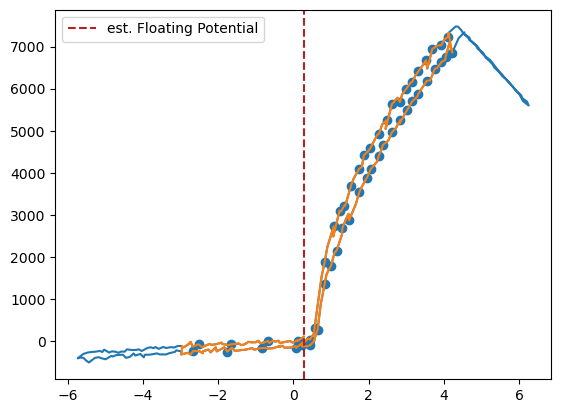

There are 75 points in V below the floating potential, out of 162
There are 77 points in V above the plasma potential, out of 162
There are 10 points in V between the floating and plasma potentials, out of 162
The Linear section will sample every 10 points
The Square Root section will sample every 2 points
The Exponential section will sample every 1 points


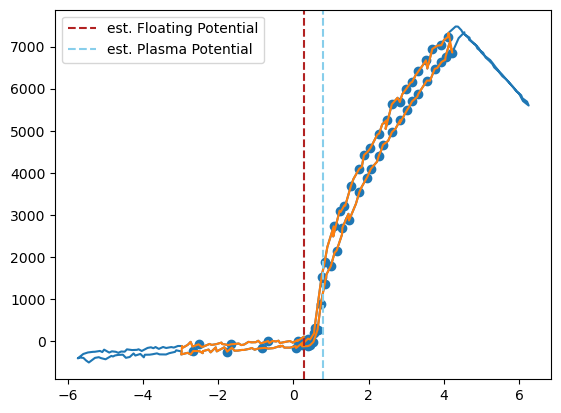

In [12]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

fp = getFloatingPotential(V, I)
plsm = getPlasmaPotential(V, I)

x,y = data_processing(V,I)


#nx, ny = num_list(x,y,50)

#nx = cut_list(x,(1/4))
#ny = cut_list(y,(1/4))

nx, ny = lin_sqrt_sample(x, y, fp, (1/10), (1/2))

plt.plot(V,I)
plt.plot(x,y)
plt.scatter(nx,ny)

plt.axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
# plt.axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
plt.legend()
plt.show()


nx, ny = lin_exp_sqrt_sample(x, y, fp, plsm, (1/10), 1, (1/2))

plt.plot(V,I)
plt.plot(x,y)
plt.scatter(nx,ny)

plt.axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
plt.axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
plt.legend()
plt.show()

In [26]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

fp = getFloatingPotential(V, I)
plsm = getPlasmaPotential(V, I)




V_pros, I_pros = data_processing(V,I)

x, y, popt, pcov = gen_fit(V_pros, I_pros, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (all {len(V_pros)} points) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (all {len(V_pros)} points) = {round(temp_e, 3)} K')
print('')




nx, ny = lin_sqrt_sample(V_pros, I_pros, fp, (1/5), (9/10))

x, y, popt, pcov = gen_fit(nx, ny, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (sample of {len(nx)} points out of {len(V_pros)}) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (sample of {len(nx)} points out of {len(V_pros)}) = {round(temp_e, 3)} K')
print('')




nx, ny = lin_exp_sqrt_sample(V_pros, I_pros, fp, plsm, (1/5), (1/1), (9/10))

x, y, popt, pcov = gen_fit(nx, ny, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (sample of {len(nx)} points out of {len(V_pros)}) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (sample of {len(nx)} points out of {len(V_pros)}) = {round(temp_e, 3)} K')

The estimated floating potential is 0.28 V.
The estimated plasma potential is 0.774 V.
Electron density fit (all 162 points) = 6.1489e+10 particles/cubic meter
Electron temperature fit (all 162 points) = 1056.902 K

There are 75 points in V below the floating potential, out of 162
There are 87 points in V above the floating potential, out of 162
The Linear section will sample every 5 points
The Square Root section will sample every 2 points
Electron density fit (sample of 59 points out of 162) = 5.6931e+10 particles/cubic meter
Electron temperature fit (sample of 59 points out of 162) = 812.661 K

There are 75 points in V below the floating potential, out of 162
There are 77 points in V above the plasma potential, out of 162
There are 10 points in V between the floating and plasma potentials, out of 162
The Linear section will sample every 5 points
The Square Root section will sample every 2 points
The Exponential section will sample every 1 points
Electron density fit (sample of 65 po

Electron density fit (162 processed points) = 6.1489e+10 particles/cubic meter
Electron temperature fit (162 processed points) = 1056.902 K



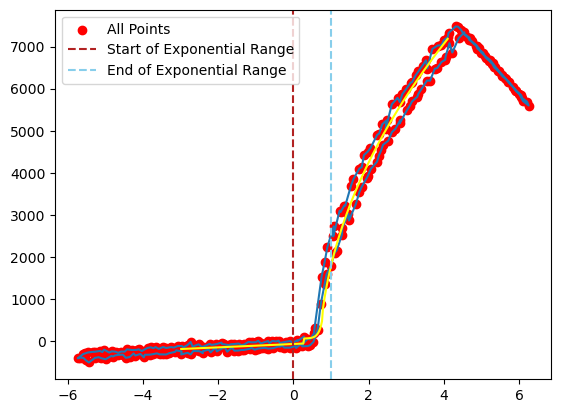

Sampling every 10 points in the Linear Section
Sampling every 1 points in the Exponential Section
Sampling every 2 points in the Square Root Section
Using (13/126) linear points, (23/23) exponential points, and (58/116) square root points, for a total of 94
Electron density fit (sample of 66 points out of 94 out of 265) = 6.1242e+10 particles/cubic meter
Electron temperature fit (sample of 66 points out of 94 out of 265) = 1052.8 K


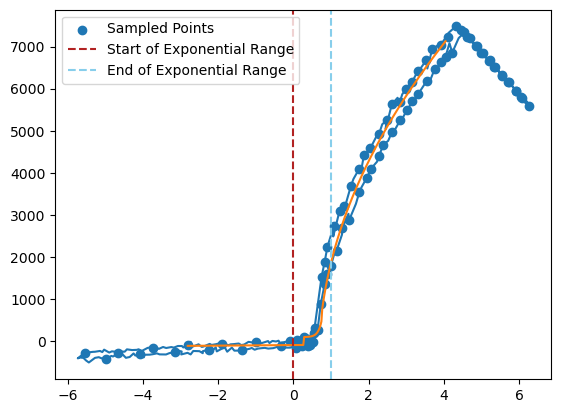

[0.21563396675386315, 0.388139707835748, 0.4404729101864362, 0.5451393148877983, 0.5587071821639, 0.7467190572756124, 0.826187994178504, 0.899842130820204, 1.0684713383946303, 1.2254709454466806, 1.347581750931603, 1.5259022922746723, 1.7468647021997725, 1.870913774438435, 2.0453577822740456, 2.276011525967796, 2.4717764680944256, 2.6113316743629156, 2.8245410172731056, 2.9931702248475247, 3.150169831899582, 3.3168607727202684, 3.5184405151080895, 3.6870697226825158, 3.929353066898635, 4.096044007719335, 4.3073150838757925, 4.458499890666651, 4.607746430703784, 4.8616593754422865, 4.993461514695859, 5.226053525143342, 5.357855664396908, 5.541991006001162, 5.718373280590505, 5.919953022978319, 6.040125561709523, 6.247520104358522, 6.082767430291561, 5.916076489470868, 5.708681946821855, 5.549744073016086, 5.332658196598437, 5.198917790591132, 5.036103383277897, 4.850029774919911, 4.677524033838033, 4.539907094323276, 4.218154813204265, 4.039834271861189, 3.9312913336523607, 3.7529707923

In [27]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']


V_pros, I_pros = data_processing(V,I)

x, y, popt, pcov = gen_fit(V_pros, I_pros, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit ({len(V_pros)} processed points) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit ({len(V_pros)} processed points) = {round(temp_e, 3)} K')
print('')


plt.plot(V,I)
plt.plot(x,y, color = 'yellow')
plt.scatter(V,I, color = 'r', label = 'All Points')

plt.axvline(x = 0, linestyle = '--', color = 'firebrick', label = 'Start of Exponential Range')
plt.axvline(x = 1, linestyle = '--', color = 'skyblue', label = 'End of Exponential Range')
plt.legend()
plt.show()


sx, sy = lin_exp_sqrt_sample_perc(V, I, (0.1), (1.00), (0.5))  # (0.20), (0.45), (0.35)

nx, ny = data_processing(sx,sy)

x, y, popt, pcov = gen_fit(nx, ny, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne = popt[5]
temp_e = popt[6]

print(f'Electron density fit (sample of {len(nx)} points out of {len(sx)} out of {len(V)}) = {"{:.4e}".format(ne)} particles/cubic meter')
print(f'Electron temperature fit (sample of {len(nx)} points out of {len(sx)} out of {len(V)}) = {round(temp_e, 3)} K')


plt.plot(V,I)
plt.plot(x,y)
plt.scatter(sx,sy, label = 'Sampled Points')

plt.axvline(x = 0, linestyle = '--', color = 'firebrick', label = 'Start of Exponential Range')
plt.axvline(x = 1, linestyle = '--', color = 'skyblue', label = 'End of Exponential Range')
plt.legend()
plt.show()

print(sx)

# Histograms

In [59]:
startingSweep = 1000
stoppingSweep = 1800

fp_list = getFloatingPotentialList(startingSweep, stoppingSweep)

print(f'Calculated {len(fp_list)} floating potentials')
print(f'Highest Floating Potential: {max(fp_list)} V')
print(f'Lowest Floating Potential: {min(fp_list)} V')
print(f'Mean Floating Potential: {round(np.mean(fp_list), 3)} V')
print(f'Median Floating Potential: {np.median(fp_list)} V')

Calculated 800 floating potentials
Highest Floating Potential: 0.488 V
Lowest Floating Potential: 0.005 V
Mean Floating Potential: 0.269 V
Median Floating Potential: 0.272 V


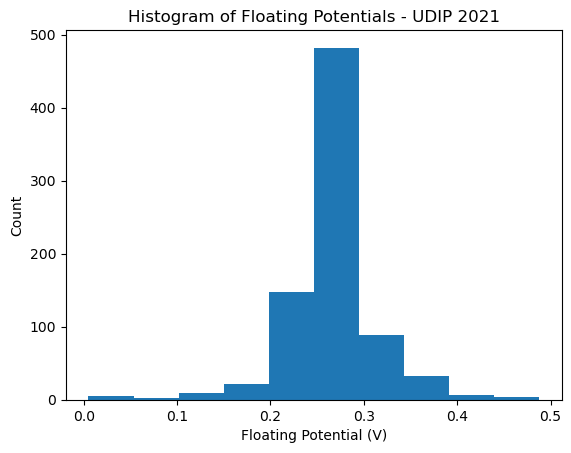

In [60]:
plt.hist(fp_list)
plt.title('Histogram of Floating Potentials - UDIP 2021')
plt.xlabel('Floating Potential (V)')
plt.ylabel('Count')
plt.show() 

In [61]:
startingSweep = 1000
stoppingSweep = 1800

plsm_list = getPlasmaPotentialList(startingSweep, stoppingSweep)

print(f'Calculated {len(plsm_list)} plasma potentials')
print(f'Highest Plasma Potential: {max(plsm_list)} V')
print(f'Lowest Plasma Potential: {min(plsm_list)} V')
print(f'Mean Plasma Potential: {round(np.mean(plsm_list), 3)} V')
print(f'Median Plasma Potential: {np.median(plsm_list)} V')

Calculated 800 plasma potentials
Highest Plasma Potential: 0.915 V
Lowest Plasma Potential: 0.602 V
Mean Plasma Potential: 0.742 V
Median Plasma Potential: 0.74 V


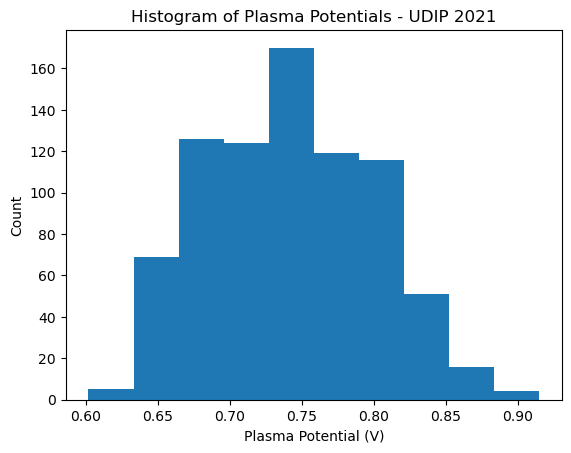

In [ ]:
plt.hist(plsm_list)
plt.title('Histogram of Plasma Potentials - UDIP 2021')
plt.xlabel('Plasma Potential (V)')
plt.ylabel('Count')
plt.show()

# Plotting Electron Density & Temperature Percent Error

In [8]:
def perc_error(experimental, actual):
    return abs((actual-experimental)/actual) * 100

In [17]:
sweepNum = 1000  # Use Sweep 1000 to 1800

V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

V_pros, I_pros = data_processing(V,I)

x, y, popt, pcov = gen_fit(V, I, True) # x is V, y is I

# ne -> popt[5], temp e -> popt[6]
ne_baseline = popt[5]
temp_e_baseline = popt[6]

print(f'Electron density fit ({len(V_pros)} processed points) = {"{:.4e}".format(ne_baseline)} particles/cubic meter')
print(f'Electron temperature fit ({len(V_pros)} processed points) = {round(temp_e_baseline, 3)} K')
print('')

#lin_perc = (1/5)
#exp_perc = (1/1)
#sqrt_perc = (1/2)

perc = np.arange(1,100,1)
#print(perc)

perc_err_ne_lin = []
perc_err_temp_lin = []

perc_err_ne_exp = []
perc_err_temp_exp = []

perc_err_ne_sqrt = []
perc_err_temp_sqrt = []

for i in perc:
    
    lin_x, lin_y = lin_exp_sqrt_sample_perc(V, I, (i/100), (1.0), (1.0))  # (0.20), (0.45), (0.35)
    n_lin_x, n_lin_y = data_processing(lin_x, lin_y)
    x, y, popt, pcov = gen_fit(n_lin_x, n_lin_y, True) # x is V, y is I
    ne_lin = popt[5]
    temp_e_lin = popt[6]
    perc_err_ne_lin.append(perc_error(ne_lin, ne_baseline))
    perc_err_temp_lin.append(perc_error(temp_e_lin, temp_e_baseline))
    
    
    exp_x, exp_y = lin_exp_sqrt_sample_perc(V, I, (1.0), (i/100), (1.0))  # (0.20), (0.45), (0.35)
    n_exp_x, n_exp_y = data_processing(exp_x, exp_y)
    x, y, popt, pcov = gen_fit(n_exp_x, n_exp_y, True) # x is V, y is I
    ne_exp = popt[5]
    temp_e_exp = popt[6]
    perc_err_ne_exp.append(perc_error(ne_exp, ne_baseline))
    perc_err_temp_exp.append(perc_error(temp_e_exp, temp_e_baseline))
    
    
    sqrt_x, sqrt_y = lin_exp_sqrt_sample_perc(V, I, (1.0), (1.0), (i/100))  # (0.20), (0.45), (0.35)
    n_sqrt_x, n_sqrt_y = data_processing(sqrt_x, sqrt_y)
    x, y, popt, pcov = gen_fit(n_sqrt_x, n_sqrt_y, True) # x is V, y is I
    ne_sqrt = popt[5]
    temp_e_sqrt = popt[6]
    perc_err_ne_sqrt.append(perc_error(ne_sqrt, ne_baseline))
    perc_err_temp_sqrt.append(perc_error(temp_e_sqrt, temp_e_baseline))


Electron density fit (162 processed points) = 6.2060e+10 particles/cubic meter
Electron temperature fit (162 processed points) = 1052.965 K



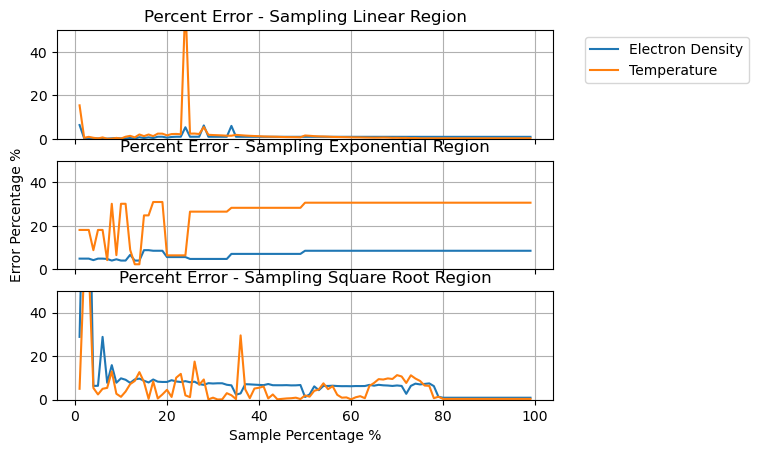

In [21]:
fig, ax = plt.subplots(3, sharex = True, sharey = False)
#fig, ax = plt.subplots(3)

ax[0].plot(perc, perc_err_ne_lin, label = 'Electron Density')
ax[0].plot(perc, perc_err_temp_lin, label = 'Temperature')
ax[0].set_title('Percent Error - Sampling Linear Region')
#ax[0].set_xlabel('Sample Percentage %')
#ax[0].set_ylabel('Error Percentage %')
ax[0].set_ylim(0,50)
ax[0].grid()
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax[1].plot(perc, perc_err_ne_exp, label = 'Electron Density')
ax[1].plot(perc, perc_err_temp_exp, label = 'Temperature')
ax[1].set_title('Percent Error - Sampling Exponential Region')
#ax[1].set_xlabel('Sample Percentage %')
ax[1].set_ylabel('Error Percentage %')
ax[1].set_ylim(0,50)
ax[1].grid()
#ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax[2].plot(perc, perc_err_ne_sqrt, label = 'Electron Density')
ax[2].plot(perc, perc_err_temp_sqrt, label = 'Temperature')
ax[2].set_title('Percent Error - Sampling Square Root Region')
ax[2].set_xlabel('Sample Percentage %')
#ax[2].set_ylabel('Error Percentage %')
ax[2].set_ylim(0,50)
ax[2].grid()
#ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#plt.savefig('Problem 6.png', dpi = 250)

plt.show()

#print(perc_err_ne_sqrt)
#print(perc_err_temp_exp)